### Imports

In [1]:
import gc
import time
import os

import numpy as np
from matplotlib import pyplot as plt

import mne

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, RocCurveDisplay, f1_score
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import MinMaxScaler

In [2]:
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten

from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from tensorflow.keras import regularizers
from pathlib import Path

import tensorflow as tf

In [3]:
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
tf.test.gpu_device_name()

'/device:GPU:0'

## Preprocessing

### Loading edf

In [5]:
edfs_path = "..\..\..\dataverse_files"

In [6]:
def load_patients_data(edfs_path):
    raw_patients_data = []
    
    edfs_file_names = [f for f in os.listdir(edfs_path) if f.endswith('.edf')]
    
    for file_name in edfs_file_names:
        path = edfs_path + '\\' + file_name 
        raw_data = mne.io.read_raw_edf(path, preload=True, verbose=False)
        raw_patients_data.append(raw_data)

    return raw_patients_data

In [7]:
raw_patients_data = load_patients_data(edfs_path)

### Filtered EEG signals segmentation

In [8]:
def get_label(edf):
    patient_edf_file_name = edf.filenames[0].split('\\')[-1]
    isSick = patient_edf_file_name.lower().startswith('s')
    return int(isSick == True) # 1 - is sick, 0 is healthy

In [9]:
def print_info(epochs_num_per_patient, labels):
    print('\nEpochs number per patient: ', epochs_num_per_patient)
    
    class_0_num = sum(labels) 
    class_1_num = len(labels)-sum(labels)

    print('\nnegative: ', class_0_num)
    print('positive: ', class_1_num)

In [10]:
def transform_patients_data_into_X_y_sets(patients_data, info=True):
    epochs_per_patient = []
    labels = []
    
    epochs_num_per_patient = []
    for edf in raw_patients_data:
        epochs = mne.make_fixed_length_epochs(edf, duration=5.0, preload=True, verbose=False)
        epochs_per_patient.append(epochs)
        epochs_num_per_patient.append(len(epochs))
        
        label = get_label(edf)
        labels.extend([label for epoch in epochs])
    
    epochs = mne.concatenate_epochs(epochs_per_patient)

    if info:
        print_info(epochs_num_per_patient, labels)
        
    del epochs_num_per_patient
    gc.collect()
    
    return (epochs, np.array(labels)) # (X, y)

In [11]:
X, y = transform_patients_data_into_X_y_sets(raw_patients_data)
del raw_patients_data
gc.collect()

Not setting metadata
5771 matching events found
No baseline correction applied
0 bad epochs dropped

Epochs number per patient:  [185, 182, 182, 185, 189, 186, 182, 182, 181, 223, 183, 180, 193, 173, 169, 229, 192, 241, 178, 148, 269, 182, 237, 170, 272, 217, 227, 434]

negative:  3165
positive:  2606


0

In [12]:
print(len(y))
print(len(X))
print(X[0].get_data().shape)

5771
5771
(1, 19, 1250)


In [13]:
X.to_data_frame().head()

,time,condition,epoch,Fp2,F8,T4,T6,O2,Fp1,F7,...,O1,F4,C4,P4,F3,C3,P3,Fz,Cz,Pz
0,0,1,0,0.002500,0.002500,0.002500,0.00250,0.002500,0.0025,0.0025,...,0.00250,0.0025,0.002500,0.0025,0.0025,0.002500,0.00250,0.0025,0.0025,0.002500
1,4,1,0,0.002500,0.002500,0.002500,0.00250,0.002500,0.0025,0.0025,...,0.00250,0.0025,0.002500,0.0025,0.0025,0.002500,0.00250,0.0025,0.0025,0.002500
2,8,1,0,0.002500,0.002500,0.002500,0.00250,0.002500,0.0025,0.0025,...,0.00250,0.0025,0.002500,0.0025,0.0025,0.002500,0.00250,0.0025,0.0025,0.002500
3,12,1,0,0.461215,0.461215,0.308310,0.30831,0.155405,0.0025,0.0025,...,0.00250,0.0025,0.002500,0.0025,0.0025,-0.150405,-0.30331,0.0025,0.0025,-0.303310
4,16,1,0,0.461215,0.461215,0.461215,0.30831,0.155405,0.0025,0.0025,...,-0.30331,0.0025,0.155405,0.0025,0.0025,-0.150405,-0.30331,0.0025,0.0025,-0.150405


### Feature Extraction (Variance)

In [14]:
np.set_printoptions(precision=50)

In [15]:
for epoch in X:
    print (epoch.shape)
    break

(19, 1250)


In [16]:
Input_N = X[0].get_data().shape[1] # input layer neurons number
print('Input_N: ', Input_N)

Output_N = 2 # classes: sick/positive = 1, not sick/negative = 0 // len(np.unique(y))
print('Output_N: ', Output_N)

Hidden_N = int(np.sqrt(Input_N*Output_N)) # neurons in hidden layer
print('Hidden_N: ', Hidden_N)

Input_N:  19
Output_N:  2
Hidden_N:  6


In [17]:
# Calculating energy for signal segments
# X = np.array([[np.sqrt(statistics.variance(channel_data)) for channel_data in epoch] for epoch in X])
X = np.array([[np.sqrt(np.var(channel_data)) for channel_data in epoch] for epoch in X])

# X = np.array([[np.var(channel_data) for channel_data in epoch] for epoch in X])

In [18]:
print(np.max(X))
print(np.min(X))

0.0019119929414324517
2.0679515313825692e-25


In [18]:
min_max_range = (0,1)
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [19]:
print(np.max(X))
print(np.min(X))

1.0000000000000002
0.0


In [20]:
X.shape

(5771, 19)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=1)

In [22]:
print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)
print('X_test: ', X_test.shape)
print('y_test: ', y_test.shape)

X_train:  (4616, 19)
y_train:  (4616,)
X_test:  (1155, 19)
y_test:  (1155,)


# MLP with Keras - binary cross entropy

In [23]:
def plot_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [24]:
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()


In [25]:
def test_model_raw_data(X_test, y_test, model, save_path = ''):
    predictions = model.predict(X_test, verbose=0)

    predictions = [0 if x < 0.5 else 1 for x in predictions]

    accuracy = accuracy_score(y_test, predictions)
    print("Test Accuracy:", accuracy)
    
    f1score = f1_score(y_test, predictions)
    print("F1 score:", f1score)
    
    ConfusionMatrixDisplay.from_predictions(y_test, predictions)
    
    to_file = len(save_path) > 0
    
    if to_file:
        plt.savefig(f'{save_path}/{model.name}-confussion-matrix.png', facecolor='white', transparent=False, dpi=500)
    
    RocCurveDisplay.from_predictions(y_test, predictions)
    
    if to_file:
        plt.savefig(f'{save_path}/{model.name}-roc-curve.png', facecolor='white', transparent=False, dpi=500)
    

In [19]:
# Input shape
input_shape = (Input_N,)

model = Sequential()

model.add(Dense(100, input_shape=input_shape, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

model.compile()

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               2000      
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 2,101
Trainable params: 2,101
Non-trainable params: 0
_________________________________________________________________


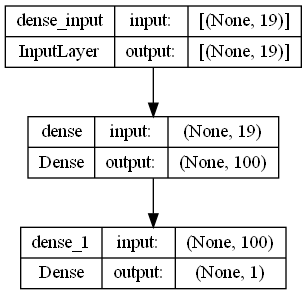

In [20]:
tf.keras.utils.plot_model(model, to_file='model_plot_mlp.png', show_shapes=True, show_layer_names=True)


In [27]:
opt = Adam(learning_rate=0.001)

In [28]:
early_stopping = EarlyStopping(monitor='val_accuracy',
                           patience=15,
                           restore_best_weights=True,
                           mode='max', 
                           verbose=1)

In [29]:
# Hyperparameters and training
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
history = model.fit(
    X_train, 
    y_train, 
    epochs=300, 
    batch_size=32, 
    verbose=1, 
    validation_split=0.2,
    callbacks=[early_stopping])

Epoch 1/300
116/116 [==============================] - 1s 5ms/step - loss: 0.6870 - accuracy: 0.5447 - val_loss: 0.6806 - val_accuracy: 0.5541
Epoch 2/300
116/116 [==============================] - 0s 4ms/step - loss: 0.6779 - accuracy: 0.5474 - val_loss: 0.6703 - val_accuracy: 0.5541
Epoch 3/300
116/116 [==============================] - 0s 4ms/step - loss: 0.6656 - accuracy: 0.5848 - val_loss: 0.6592 - val_accuracy: 0.5541
Epoch 4/300
116/116 [==============================] - 0s 4ms/step - loss: 0.6519 - accuracy: 0.6414 - val_loss: 0.6400 - val_accuracy: 0.6710
Epoch 5/300
116/116 [==============================] - 0s 4ms/step - loss: 0.6363 - accuracy: 0.6845 - val_loss: 0.6259 - val_accuracy: 0.6558
Epoch 6/300
116/116 [==============================] - 1s 4ms/step - loss: 0.6230 - accuracy: 0.6991 - val_loss: 0.6137 - val_accuracy: 0.6645
Epoch 7/300
116/116 [==============================] - 0s 4ms/step - loss: 0.6103 - accuracy: 0.7002 - val_loss: 0.6016 - val_accuracy: 0.6699

Epoch 58/300
116/116 [==============================] - 1s 4ms/step - loss: 0.3541 - accuracy: 0.8781 - val_loss: 0.3563 - val_accuracy: 0.8701
Epoch 59/300
116/116 [==============================] - 0s 4ms/step - loss: 0.3536 - accuracy: 0.8778 - val_loss: 0.3602 - val_accuracy: 0.8604
Epoch 60/300
116/116 [==============================] - 0s 4ms/step - loss: 0.3506 - accuracy: 0.8814 - val_loss: 0.3544 - val_accuracy: 0.8755
Epoch 61/300
116/116 [==============================] - 0s 4ms/step - loss: 0.3482 - accuracy: 0.8819 - val_loss: 0.3582 - val_accuracy: 0.8755
Epoch 62/300
116/116 [==============================] - 0s 4ms/step - loss: 0.3481 - accuracy: 0.8814 - val_loss: 0.3504 - val_accuracy: 0.8723
Epoch 63/300
116/116 [==============================] - 0s 4ms/step - loss: 0.3466 - accuracy: 0.8841 - val_loss: 0.3489 - val_accuracy: 0.8701
Epoch 64/300
116/116 [==============================] - 0s 4ms/step - loss: 0.3442 - accuracy: 0.8838 - val_loss: 0.3472 - val_accuracy:

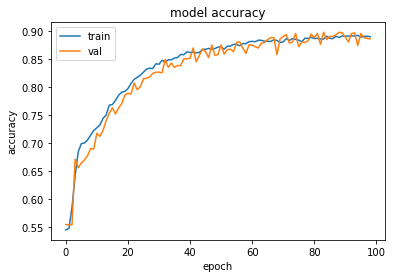

In [30]:
plot_accuracy(history)

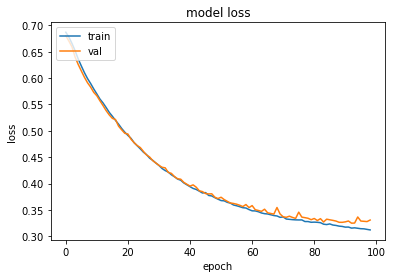

In [31]:
plot_loss(history)

In [32]:
# 765 101 866

Test Accuracy: 0.8813852813852814
F1 score: 0.8892481810832661


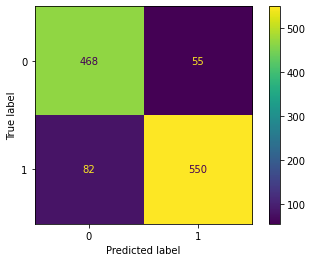

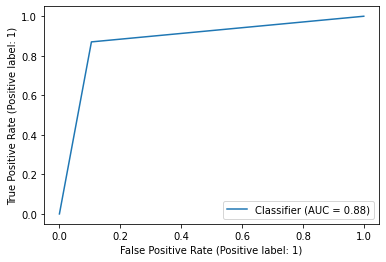

In [33]:
test_model_raw_data(X_test, y_test, model)

In [1]:
(82+55)/1155

0.11861471861471862

### Sklearn MLP Classifier

Iteration 1, loss = 0.68616040
Validation score: 0.548701
Iteration 2, loss = 0.68104565
Validation score: 0.548701
Iteration 3, loss = 0.67432024
Validation score: 0.548701
Iteration 4, loss = 0.66614120
Validation score: 0.557359
Iteration 5, loss = 0.65677921
Validation score: 0.687229
Iteration 6, loss = 0.64645604
Validation score: 0.683983
Iteration 7, loss = 0.63528018
Validation score: 0.680736
Iteration 8, loss = 0.62515815
Validation score: 0.690476
Iteration 9, loss = 0.61570089
Validation score: 0.696970
Iteration 10, loss = 0.60555869
Validation score: 0.711039
Iteration 11, loss = 0.59750554
Validation score: 0.677489
Iteration 12, loss = 0.59003943
Validation score: 0.712121
Iteration 13, loss = 0.58065377
Validation score: 0.693723
Iteration 14, loss = 0.57475955
Validation score: 0.726190
Iteration 15, loss = 0.56688441
Validation score: 0.728355
Iteration 16, loss = 0.55985894
Validation score: 0.732684
Iteration 17, loss = 0.55329232
Validation score: 0.752165
Iterat

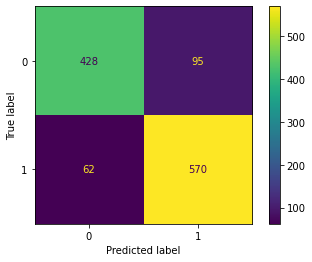

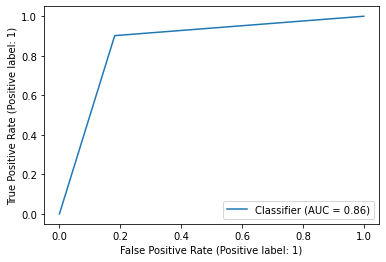

In [34]:
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

clf = MLPClassifier(random_state=1337, max_iter=300, early_stopping=True, batch_size=32,
                    validation_fraction=0.2, n_iter_no_change=15, verbose=1).fit(X_train, y_train)

y_pred = clf.predict(X_test)
res_f1_score = f1_score(y_test, y_pred)
res_acc = clf.score(X_test, y_test)

print(f"F1 Score: {res_f1_score}")
print(f"ACC: {res_acc}")


ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

RocCurveDisplay.from_predictions(y_test, y_pred)


In [2]:
(62+95)/1155

0.13593073593073593

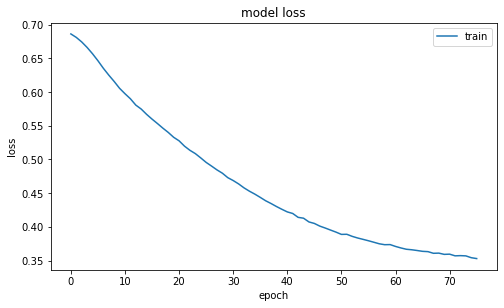

In [35]:
plt.figure(figsize=(8,10))

plt.subplot(2,1,2)
# summarize history for loss
plt.plot(clf.loss_curve_)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [36]:
clf.get_params()

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 32,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': True,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 300,
 'momentum': 0.9,
 'n_iter_no_change': 15,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': 1337,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.2,
 'verbose': 1,
 'warm_start': False}